In [1]:
from glob import glob
import json
import os
import re
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from typing import List, Dict, Mapping, Tuple, Union, Optional
from transformers import AutoTokenizer

tqdm.pandas()
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))) # Should be your path to the repo root
sys.path.insert(0, ROOT_DIR)


/home/xingyao6/opt/miniconda3/envs/llm-agent/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trajectory_files = glob(os.path.join(ROOT_DIR, "data/trajectories/medium_instances/*.jsonl"))
# trajectory_files = glob(os.path.join(ROOT_DIR, "data/trajectories/easy_instances/*.jsonl"))
# trajectory_files = glob(os.path.join(ROOT_DIR, "data/trajectories/hard_gpt4_instances/*.jsonl"))
print(f"Found {len(trajectory_files)} trajectory files")
# read everything into a dataframe
dfs = []
for trajectory_file in trajectory_files:
    with open(trajectory_file, "r") as f:
        for line in f:
            line = json.loads(line)
            dfs.append(line)
df = pd.DataFrame(dfs)
print(f"Found {len(df)} trajectories")


Found 12 trajectory files


Found 8580 trajectories


## Special Symbols

In [3]:
tokenizer = AutoTokenizer.from_pretrained("/shared/nas/data/m1/shared-resource/llm/meta-llama/Llama-2-7b-hf/")

# follow https://github.com/openai/openai-python/blob/main/chatml.md
# and https://huggingface.co/OpenAssistant/codellama-13b-oasst-sft-v10
INST_START = "<|im_start|>"
INST_END = "<|im_end|>"

"""
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
"""

# add the special tokens
tokenizer.add_special_tokens({"additional_special_tokens": [INST_START, INST_END]})
len(tokenizer)


32002

## Filter Traj for Dataset

In [4]:
df["task_name"].value_counts()


alfworld                    2099
hotpotqa                    1630
strategyqa                  1595
wiki_table_questions        1129
APPS                         667
algebra                      467
number_theory                270
intermediate_algebra         236
prealgebra                   234
counting_and_probability     120
precalculus                   73
geometry                      60
Name: task_name, dtype: int64

In [5]:
# selected = df.query("task_name == 'APPS'")
print("Length (before):", len(df))
SELECT_TASK = [
    "alfworld",
    # "strategyqa",  # leave it out, has a lot short cuts (i.e., model cannot find answer from search)
    "hotpotqa",
    "wiki_table_questions", 
    "APPS", # Code
    "algebra", "number_theory", "prealgebra", "intermediate_algebra", "counting_and_probability", "precalculus", "geometry"  # MATH
]
selected = df.query("task_name in @SELECT_TASK")
print("Length (after):", len(selected))
print(selected["task_name"].value_counts())


Length (before): 8580
Length (after): 6985
alfworld                    2099
hotpotqa                    1630
wiki_table_questions        1129
APPS                         667
algebra                      467
number_theory                270
intermediate_algebra         236
prealgebra                   234
counting_and_probability     120
precalculus                   73
geometry                      60
Name: task_name, dtype: int64


In [6]:
# Straightforward filtering
assert selected["success"].nunique() == 1, "There should only be one value for success (1)"

print("Length (before):", len(selected))
# 1. remove all tasks that are have (n_turns - 1) invalid_action
selected = selected[~((selected["n_turns"] - 1) == selected["invalid_action"])]
print("Length (after remove invalid_action):", len(selected))

# 2. remove strategyqa tasks that success with proposed solution == 2
# UPDATE: We obanonded this dataset entirely
selected = selected[~((selected["task_name"] == "strategyqa") & (selected["propose_solution"] == 2))]
print("Length (after remove strategyqa propose=2 success):", len(selected))


Length (before): 6985
Length (after remove invalid_action): 6955
Length (after remove strategyqa propose=2 success): 6955


In [7]:
def data_filtering_heuritics(row) -> bool:
    """Return true if the state should be kept."""
    state = row["state"]
    history = state["history"]
    # print(f"History length: {len(history)}")
    # exclude the first system message + instruction AND final assistant message (with no user response)
    history = history[1:-1]
    
    # 1. This is a werid case where the assistant is not responding to the user
    if len(history) % 2 != 0:
        print(f"[Instance Removed] History length is odd: {len(history)}")
        return False
    # assert len(history) % 2 == 0, f"History should be even length. But got {len(history)}."

    # Collect assistant and user messages
    paired_assistant_user_pairs = []
    for i in range(0, len(history), 2):
        assistant = history[i]["content"]
        user = history[i + 1]["content"]
        # print(f"ASSISTANT:\n{assistant}")
        # print(f"USER:\n{user}")
        paired_assistant_user_pairs.append((assistant, user))

    # 2. Remove all <execute> outputs that *all* causes some sort of error (and eventually got it right?)
    # This keeps the ones that are eventually correct and may or may not have errors in the beginning
    if all(
        (
        "<solution>" in assistant_content 
         or ("<execute>" in assistant_content and "Error" in user_content)
        )
        for assistant_content, user_content in paired_assistant_user_pairs
    ):  
        return False

    return True

def convert_state_to_traj(state):
    STRIP_WORDS = [
        "Assistant:",
    ]
    history = state["history"]
    res = ""

    for i, turn in enumerate(history):
        role = turn["role"]
        text = turn["content"].strip()
        for word in STRIP_WORDS:
            text = text.lstrip(word)
        text = text.strip()
        if i == 0:
            assert role == "user"
            # specifically handle the first turn
            splited_text = text.split("\n---\n\nTask:")
            assert len(splited_text) == 3, f"Expecting 3 parts. But got {len(splited_text)} parts: \n{text}"
            system_message, in_context_example, task = splited_text
            res += f"{INST_START}system\n{system_message.strip()}{INST_END}\n"
            res += f"{INST_START}user\nTask:\n{task.strip()}{INST_END}\n"

        elif role == "user":
            res += f"{INST_START}user\n{text}{INST_END}\n"
        elif role == "assistant":
            res += f"{INST_START}assistant\n{text}{INST_END}\n"
    return res

SYSTEM_MSG_TO_REPLACE = """At each turn, you should first provide your step-by-step thinking for solving the task. Your thought process should be enclosed using "<thought>" tag, for example: <thought> I need to print "Hello World!" </thought>.

After that, you have two options:"""

SYSTEM_MSG_NEW = """At each turn, you should first provide your step-by-step thinking for solving the task. After that, you have two options:"""

def convert_state_to_traj(state) -> List[Mapping[str, str]]:
    STRIP_WORDS = [
        "Assistant:",
    ]
    history = state["history"]
    res = []

    def _fix_weird_str(string):
        string = string.replace("Assistant\uff1a", "")
        string = string.replace("Assistant:", "")
        return string

    for i, turn in enumerate(history):
        role = turn["role"]
        text = turn["content"].strip()
        for word in STRIP_WORDS:
            text = text.lstrip(word)
        text = text.strip()
        if i == 0:
            assert role == "user"
            # specifically handle the first turn
            splited_text = text.split("\n---\n\nTask:")
            assert len(splited_text) == 3, f"Expecting 3 parts. But got {len(splited_text)} parts: \n{text}"
            system_message, in_context_example, task = splited_text
            system_message = system_message.replace(SYSTEM_MSG_TO_REPLACE, SYSTEM_MSG_NEW)
            # res += f"{INST_START}system\n{system_message.strip()}{INST_END}\n"
            res.append({
                "role": "system",
                "content": system_message.strip()
            })
            # res += f"{INST_START}user\nTask:\n{task.strip()}{INST_END}\n"
            res.append({
                "role": "user",
                "content": f"Task:\n{task.strip()}"
            })

        elif role == "user":
            res.append({
                "role": "user",
                "content": text
            })
        elif role == "assistant":
            # replace <thought> and </thought> with empty string, but keep the content between them
            # if is on a separate line, remove the line
            # do not capture the space right after <thought> and before </thought>
            text = re.sub(r"<thought>(.*?)</thought>", lambda match: match.group(1).strip(), text, flags=re.DOTALL)

            res.append({
                "role": "assistant",
                "content": _fix_weird_str(text)
            })
    return res

def format_traj_to_str(traj: List[Mapping[str, str]]) -> str:
    res = ""
    for turn in traj:
        res += f"{INST_START}{turn['role']}\n{turn['content']}{INST_END}\n"
    return res

def visualize_traj(traj: List[Mapping[str, str]]):
    print("==========================")
    for turn in traj:
        if turn["role"] == "user":
            print("\033[1;34;40m" + f"USER:\n{turn['content']}" + "\033[0m")
            print("==========================")
        elif turn["role"] == "assistant":
            # green for assistant
            print("\033[1;32;40m" + f"ASSISTANT:\n{turn['content']}" + "\033[0m")
            print("==========================")
        elif turn["role"] == "system":
            # yellow for system
            print("\033[1;33;40m" + f"SYSTEM:\n{turn['content']}" + "\033[0m")
            print("==========================")


In [8]:
selected = selected.assign(keep=selected.apply(data_filtering_heuritics, axis=1))
selected["keep"].value_counts()


[Instance Removed] History length is odd: 5
[Instance Removed] History length is odd: 5
[Instance Removed] History length is odd: 5
[Instance Removed] History length is odd: 7
[Instance Removed] History length is odd: 5
[Instance Removed] History length is odd: 5


True     6728
False     227
Name: keep, dtype: int64

In [9]:
selected.groupby("task_name")["keep"].value_counts()


task_name                 keep 
APPS                      True      573
                          False      69
alfworld                  True     2031
                          False      68
algebra                   True      462
                          False       5
counting_and_probability  True      119
geometry                  True       59
hotpotqa                  True     1618
                          False      11
intermediate_algebra      True      234
                          False       2
number_theory             True      269
                          False       1
prealgebra                True      227
                          False       5
precalculus               True       71
                          False       2
wiki_table_questions      True     1065
                          False      64
Name: keep, dtype: int64

In [47]:
# # Look at filtered data
# visualize_traj_str(convert_state_to_traj_str(selected[~selected["keep"]].sample(1).iloc[0]["state"]))


# Process Kept Data

Total number of data points: 6728


task_name
APPS                         573
alfworld                    2031
algebra                      462
counting_and_probability     119
geometry                      59
hotpotqa                    1618
intermediate_algebra         234
number_theory                269
prealgebra                   227
precalculus                   71
wiki_table_questions        1065
Name: id, dtype: int64

task_type
code_generation     573
decision_making    2031
reasoning          3059
tabular            1065
Name: id, dtype: int64

<Axes: ylabel='task_name'>

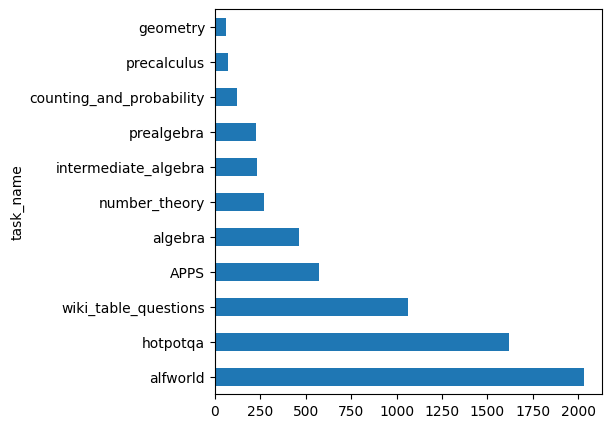

In [10]:
# Look at keep data
kept_data = selected[selected["keep"]]
# assign a unique id to each data point
def get_id(row):
    return f"{row['task_type']}/{row['task_name']}/{row['task_id']}/{row['agent_model_name']}/{row['exp_setting']}"
kept_data = kept_data.assign(id=kept_data.apply(get_id, axis=1))
print(f"Total number of data points: {len(kept_data)}")

# distribution of data points
# kept_data.groupby("task_name")["id"].count().sort_values(ascending=False)
display(kept_data.groupby("task_name")["id"].count())
display(kept_data.groupby("task_type")["id"].count())
# Make it a bar chart with task_name on y-axis and count on x-axis AND annotate the count on the bar
kept_data.groupby("task_name")["id"].count().sort_values(ascending=False).plot.barh(figsize=(5, 5))


In [11]:
visualize_traj(convert_state_to_traj(kept_data.sample(1).iloc[0]["state"]))


SYSTEM:
You are a helpful assistant assigned with the task of problem-solving. To achieve this, you will be using an interactive coding environment equipped with a variety of tool functions to assist you throughout the process.

At each turn, you should first provide your step-by-step thinking for solving the task. After that, you have two options:

1) Interact with a Python programming environment and receive the corresponding output. Your code should be enclosed using "<execute>" tag, for example: <execute> print("Hello World!") </execute>.
2) Directly provide a solution that adheres to the required format for the given task. Your solution should be enclosed using "<solution>" tag, for example: The answer is <solution> A </solution>.

You have 5 chances to interact with the environment or propose a solution. You can only propose a solution 2 times.

Tool function available (already imported in <execute> environment):
[1] wikipedia_search(query: str) -> str
The Wikipedia Search tool p

Got 6728 trajectories


100%|██████████| 6728/6728 [00:27<00:00, 247.66it/s]


<Axes: xlabel='conversations', ylabel='Proportion'>

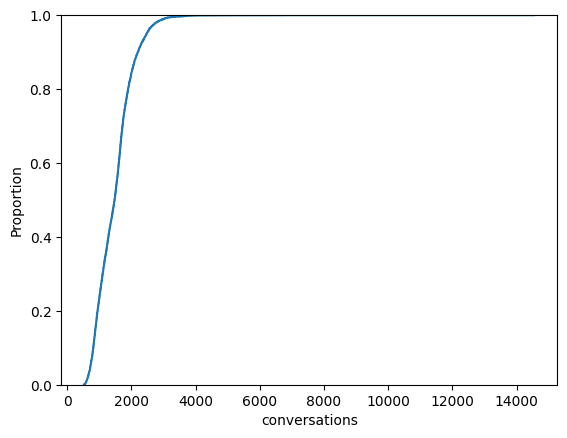

In [12]:
output_traj = pd.concat(
    [
        kept_data["id"],
        kept_data["state"].apply(convert_state_to_traj),
    ],
    axis=1
).rename(columns={"state": "conversations"})
print(f"Got {len(output_traj)} trajectories")
output_traj_length = output_traj["conversations"].progress_apply(lambda x: len(tokenizer(format_traj_to_str(x)).input_ids))
# display(output_traj_length.plot.hist(bins=100))
# Do a ecdf plot
display(sns.ecdfplot(output_traj_length))


In [47]:
output_traj.to_json(os.path.join(ROOT_DIR, "data/datasets/oct28_full6728.jsonl"), orient="records", lines=True)
# output_traj.to_json(os.path.join(ROOT_DIR, "data/datasets/oct30_easy8155.jsonl"), orient="records", lines=True)
# output_traj.to_json(os.path.join(ROOT_DIR, "data/datasets/nov2_gpt4hard411.jsonl"), orient="records", lines=True)
